# Data visualization for the different parks gathered

In the process of data preprocessing, the bolded out points below is the focus of this notebook.

Plan:

- Transform data
    - Pretend current wind predictions are measurements
    - Transform degrees into cos and sin values

- Divide into parks, and for each park:
    - Overview over NaN values and how to deal with them
    - Autocorrelation over wind speed, wind direction, production
    - How much does the wind speed and wind direction change when the forecast is updated?
    - How is the wind speed and the production correlated?

- Look at data for all parks
    - **Normalize data for all parks (max production at each park is 1)**
    - **Look at correlations between production at the different parks**
    - **Look at correlations again, this time after splitting the data into wind direction quadrant**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from sklearn import preprocessing
from statsmodels.graphics.tsaplots import plot_acf, acf, pacf, plot_pacf

import sys
import os

from satprod.data_handlers.num_data import NumericalDataHandler
from satprod.data_handlers.data_utils import get_columns

In [2]:
pd.set_option("display.max_rows", 700, "display.max_columns", 50)

In [3]:
num = NumericalDataHandler()
data = num.read_formatted_data(nan=False)
data = data[[c for c in data.columns if '+' not in c]]

# the no nan data is not available for the test set times, so there is nothing to remove
#split = datetime(2020, 5, 1, 0)
#data = data[data.index < split]

wind = get_columns(data, 'wind')
prod = get_columns(data, 'production')

## Functions

In [4]:
def max_min_df_scaler(df):
    x = df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, index=df.index, columns=df.columns)
wind
def heatmaps_park_productions_lags(prod, lag_limit: int=5):
    prod_shift = pd.DataFrame()
    names = []
    for j in range(len(prod.columns)):
        for i in range(0, lag_limit):
            new = prod[prod.columns[j]].shift(i)
            names.append(f'{prod.columns[j]}_shift_{i}')
            prod_shift = pd.concat([prod_shift, new], axis=1)
    prod_shift.columns = names

    prod_shift_bess_skom = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'skom' in col]
    prod_shift_bess_yvik = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'yvik' in col]
    prod_shift_bess_vals = [col for col in prod_shift.columns if 'bess' in col] + [
        col for col in prod_shift.columns if 'vals' in col]
    prod_shift_yvik_vals = [col for col in prod_shift.columns if 'yvik' in col] + [
        col for col in prod_shift.columns if 'vals' in col]

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_skom].corr(), ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_yvik].corr(), ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_bess_vals].corr(), ax=ax)
    plt.show()

    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(prod_shift[prod_shift_yvik_vals].corr(), ax=ax)
    plt.show()
    
def plot_direction_relations(month: int):
    plt.figure(figsize=(16,4))
    plt.title(month)
    for col in df_cos.columns:
        plt.plot(df_cos[df_cos.index.month == 1][col].values)
    plt.title(f'sin of wind direction among the parks in month number {month}')
    plt.show()

    plt.figure(figsize=(16,4))
    plt.title(month)
    for col in df_sin.columns:
        plt.plot(df_sin[df_sin.index.month == 1][col].values)
    plt.title(f'sin of wind direction among the parks in month number {month}')
    plt.show()

    plt.title(f'correlation of cos of wind direction in month number {month}')
    sns.heatmap(df_cos[df_cos.index.month == month].corr())
    plt.show()

    plt.title(f'correlation of sin of wind direction in month number {month}')
    sns.heatmap(df_sin[df_sin.index.month == month].corr())
    plt.show()
    
def plot_production_wind_speed(wind, prod):
    start, stop=20000, 20000+240
    plt.figure(figsize=(16,8))
    plt.plot(wind.iloc[start:stop].index, prod.production_bess.values[start:stop], label='bess')
    plt.plot(wind.iloc[start:stop].index, prod.production_skom.values[start:stop], label='skom')
    plt.plot(wind.iloc[start:stop].index, prod.production_vals.values[start:stop], label='vals')
    plt.plot(wind.iloc[start:stop].index, prod.production_yvik.values[start:stop], label='yvik')
    plt.legend()
    plt.title('Normalized production at the different parks')
    plt.xlabel('hours')
    plt.show()

    plt.figure(figsize=(16,8))
    plt.plot(wind.iloc[start:stop].index, wind.wind_speed_bess.values[start:stop], label='bess')
    plt.plot(wind.iloc[start:stop].index, wind.wind_speed_skom.values[start:stop], label='skom')
    plt.plot(wind.iloc[start:stop].index, wind.wind_speed_vals.values[start:stop], label='vals')
    plt.plot(wind.iloc[start:stop].index, wind.wind_speed_yvik.values[start:stop], label='yvik')
    plt.legend()
    plt.title('Wind speed at the different parks (bess and skom have identical wind speeds)')
    plt.xlabel('hours')
    plt.show()
    
def plot_correlations_given_direction(direction: str, park_for_direction_filter: str):
    df = pd.concat([wind, prod], axis=1)
    if direction=='SW':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] < 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] < 0]
        prod_SW = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_SW.asfreq('H'), lag_limit=10)
    elif direction=='SE':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] > 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] < 0]
        prod_SE = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_SE.asfreq('H'), lag_limit=10)
    elif direction=='NW':
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] < 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] > 0]
        prod_NW = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_NW.asfreq('H'), lag_limit=10)
    else:
        df = df[df[f'wind_direction_{park_for_direction_filter}_sin'] > 0]
        df = df[df[f'wind_direction_{park_for_direction_filter}_cos'] > 0]
        prod_NE = max_min_df_scaler(get_columns(df, 'prod'))
        heatmaps_park_productions_lags(prod_NE.asfreq('H'), lag_limit=10)
        
def plot_direction_comparison(df_cos, df_sin):
    start = '2019-01-01 00:00:00'
    stop = '2019-01-31 23:00:00'
    plt.figure(figsize=(16,4))
    for col in df_cos.columns:
        df_cos[col].loc[start:stop].plot()
    plt.title('cos of wind direction among the parks in Jan 2019')
    plt.show()

    plt.figure(figsize=(16,4))
    for col in df_sin.columns:
        df_sin[col].loc[start:stop].plot()
    plt.title('sin of wind direction among the parks in Jan 2019')
    plt.show()
    
def correlation_through_year(df_sin, df_cos):
    cos_corrs = {'bess-vals': [], 'bess-yvik': [], 'yvik-vals': []}
    sin_corrs = {'bess-vals': [], 'bess-yvik': [], 'yvik-vals': []}

    for j in [(0,2,'bess-vals'),(0,3,'bess-yvik'),(2,3,'yvik-vals')]:
        for month in range(1,13):
            cos_corrs[j[2]].append(df_cos[df_cos.index.month == month].corr().values[j[0],j[1]])
            sin_corrs[j[2]].append(df_sin[df_sin.index.month == month].corr().values[j[0],j[1]])

    plt.figure(figsize=(16,4))
    for key, value in sin_corrs.items():
        plt.scatter(np.arange(1, len(value)+1), value, label=key+'_sin')
        plt.scatter(np.arange(1, len(value)+1), cos_corrs[key], label=key+'_cos')
    plt.xlabel('month of the year')
    plt.ylabel('correlation')
    plt.legend()

## Production and wind speed at different parks gathered

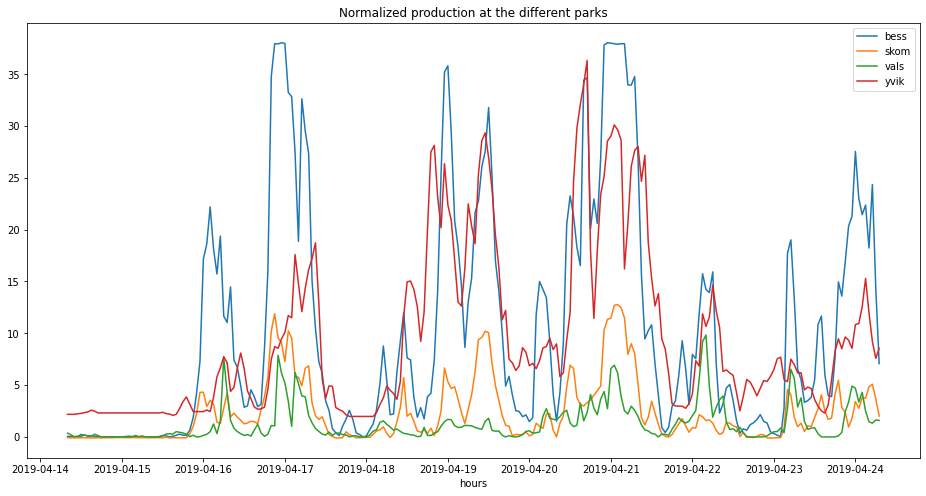

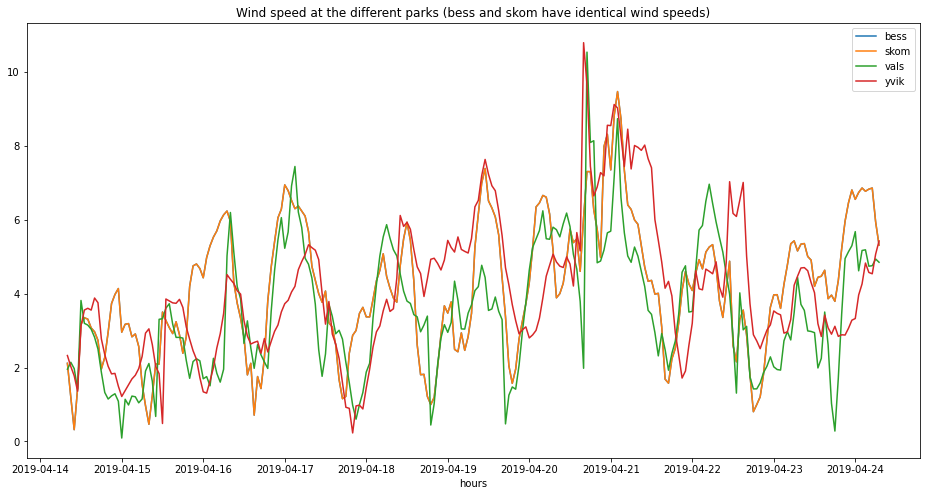

In [5]:
plot_production_wind_speed(wind, prod)

## Correlation of production at the different parks for all time points

In [6]:
prod = max_min_df_scaler(prod)

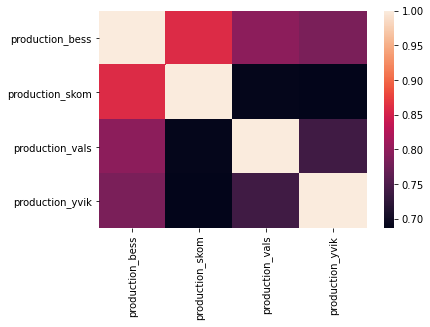

In [7]:
sns.heatmap(prod.corr())
plt.show()

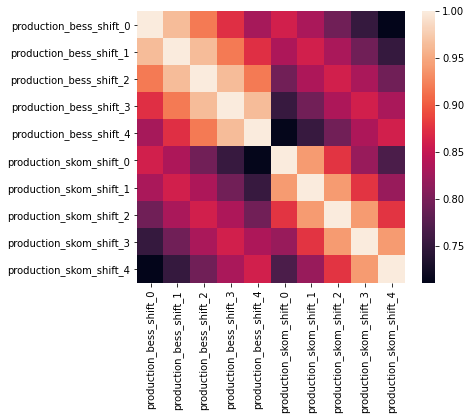

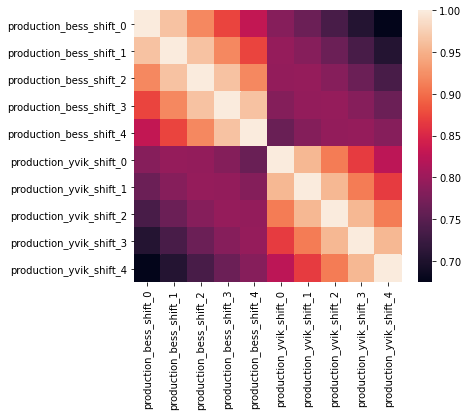

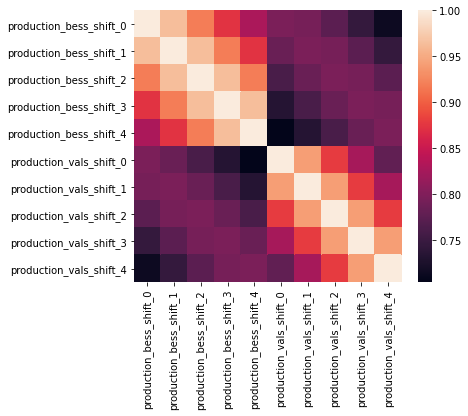

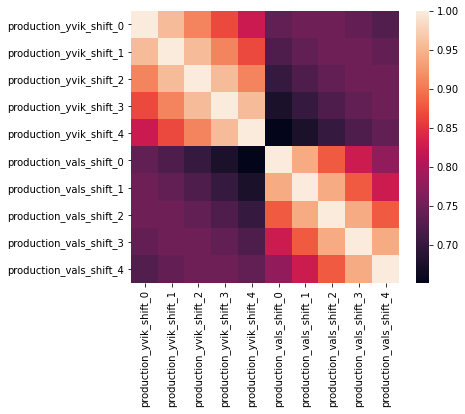

In [8]:
heatmaps_park_productions_lags(prod, lag_limit=5)

- Production at the different parks are very correlated
- Production at Yvik in lags -1, -2 is correlated to 0 at the other parks
- Production at Vals in lags 0, 1 is correlated to 0 at Bess and Skom
- Production at Vals in lags 1, 2 is correlated to 0 at Yvik

This means that Yvik "knows" that there is going to be a rise in production at Bess and Skom 1-2 hours in advance, and that the production at Bess and Skom gives the same information about Vals 0-1 hours before.

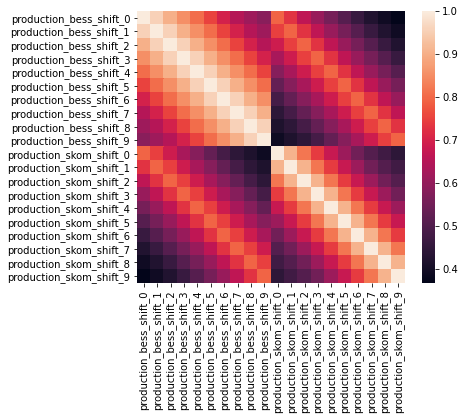

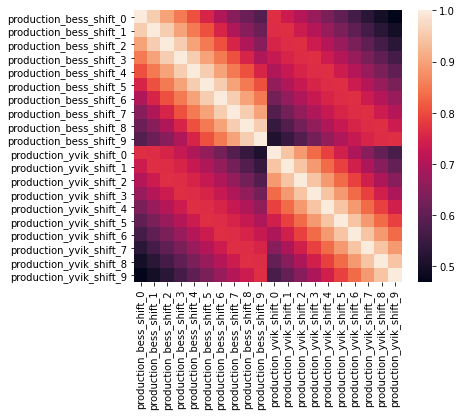

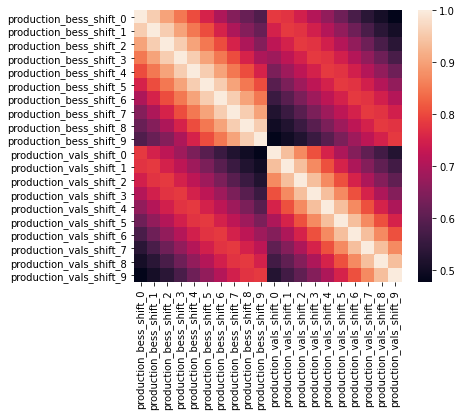

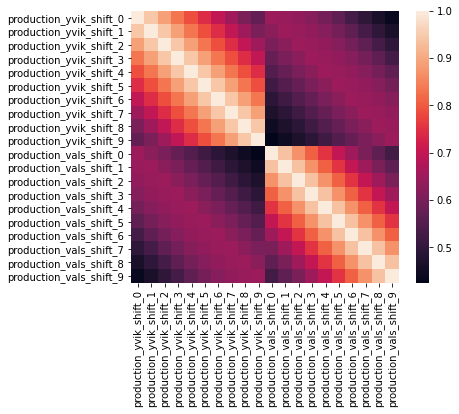

In [9]:
park_for_direction_filter = 'vals'
direction = 'SW'
plot_correlations_given_direction(direction, park_for_direction_filter)

## How often is the wind direction more or less the same at all parks?

In [10]:
df = get_columns(wind, 'direction')
df_sin = get_columns(df, 'sin')
df_cos = get_columns(df, 'cos')

In [11]:
df_sin.corr()

,wind_direction_bess_sin,wind_direction_skom_sin,wind_direction_vals_sin,wind_direction_yvik_sin
wind_direction_bess_sin,1.000000,1.000000,0.876700,0.815829
wind_direction_skom_sin,1.000000,1.000000,0.876700,0.815829
wind_direction_vals_sin,0.876700,0.876700,1.000000,0.752753
wind_direction_yvik_sin,0.815829,0.815829,0.752753,1.000000


In [12]:
df_cos.corr()

,wind_direction_bess_cos,wind_direction_skom_cos,wind_direction_vals_cos,wind_direction_yvik_cos
wind_direction_bess_cos,1.000000,1.000000,0.824381,0.803385
wind_direction_skom_cos,1.000000,1.000000,0.824381,0.803385
wind_direction_vals_cos,0.824381,0.824381,1.000000,0.755053
wind_direction_yvik_cos,0.803385,0.803385,0.755053,1.000000


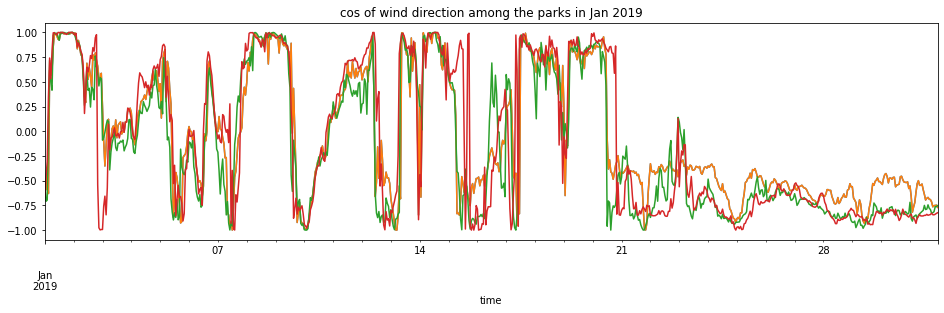

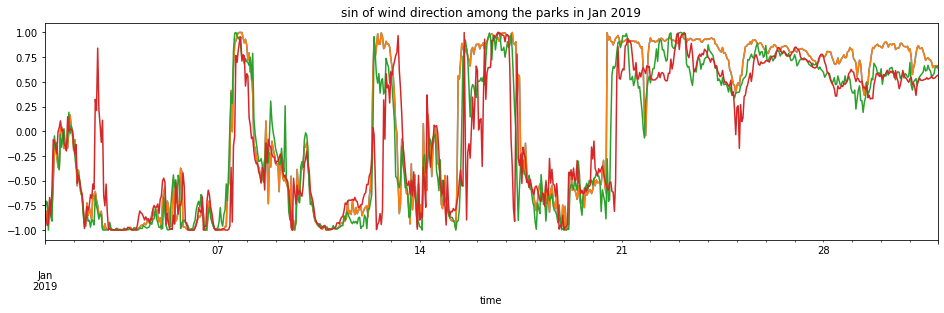

In [13]:
plot_direction_comparison(df_cos, df_sin)

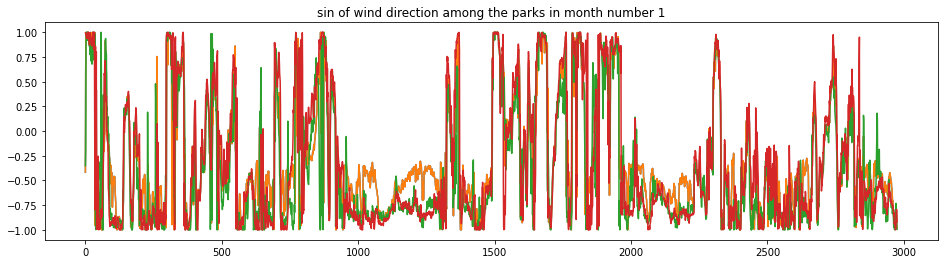

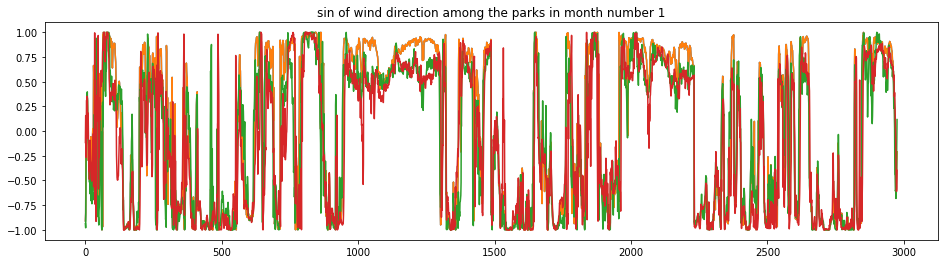

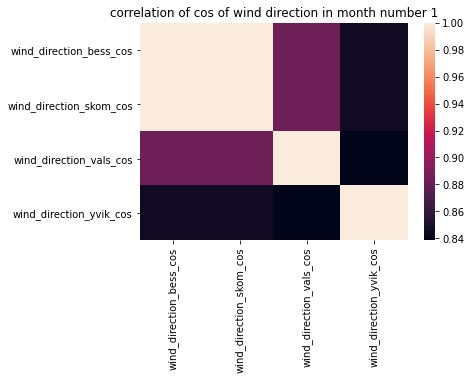

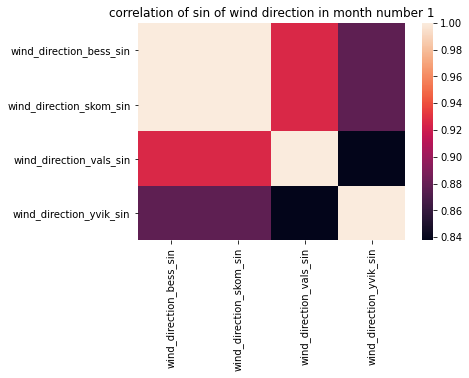

In [14]:
# given month, plot sin and cos values and correlation
month = 1
plot_direction_relations(month)

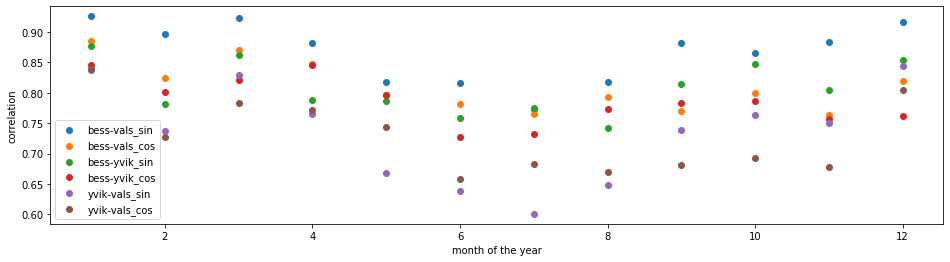

In [15]:
correlation_through_year(df_sin, df_cos)